In [1]:
import yfinance as yf
import pandas as pd
dataset = yf.download('AAPL')


[*********************100%***********************]  1 of 1 completed


In [2]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600
...,...,...,...,...,...,...
2023-06-13,182.800003,184.149994,182.440002,183.309998,183.309998,54929100
2023-06-14,183.369995,184.389999,182.020004,183.949997,183.949997,57462900
2023-06-15,183.960007,186.520004,183.779999,186.009995,186.009995,65433200


In [3]:
yf.download('Apple Adjusted Close Price')

[*********************100%***********************]  4 of 4 completed

4 Failed downloads:
- APPLE: No timezone found, symbol may be delisted
- CLOSE: No timezone found, symbol may be delisted
- PRICE: No timezone found, symbol may be delisted
- ADJUSTED: No timezone found, symbol may be delisted


Empty DataFrame
Columns: [(Adj Close, ADJUSTED), (Adj Close, APPLE), (Adj Close, CLOSE), (Adj Close, PRICE), (Close, ADJUSTED), (Close, APPLE), (Close, CLOSE), (Close, PRICE), (High, ADJUSTED), (High, APPLE), (High, CLOSE), (High, PRICE), (Low, ADJUSTED), (Low, APPLE), (Low, CLOSE), (Low, PRICE), (Open, ADJUSTED), (Open, APPLE), (Open, CLOSE), (Open, PRICE), (Volume, ADJUSTED), (Volume, APPLE), (Volume, CLOSE), (Volume, PRICE)]
Index: []

[0 rows x 24 columns]

In [4]:
dataset1 = pd.DataFrame(dataset['Adj Close'])

In [5]:
dataset1

,Adj Close
Date,
1980-12-12,0.099584
1980-12-15,0.094388
1980-12-16,0.087461
1980-12-17,0.089625
1980-12-18,0.092224
...,...
2023-06-13,183.309998
2023-06-14,183.949997
2023-06-15,186.009995


In [6]:
#checking missing values
dataset1.isna().sum()

Adj Close    0
dtype: int64

In [7]:
#detecting outliers and removing using Tukey's method
import numpy as np
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return pd.DataFrame(data[(data <= upper_fence) & (data >= lower_fence)])

In [8]:
dataset1 =iqr_outliers(dataset1)
dataset1

,Adj Close
Date,
1980-12-12,0.099584
1980-12-15,0.094388
1980-12-16,0.087461
1980-12-17,0.089625
1980-12-18,0.092224
...,...
2023-06-13,NaN
2023-06-14,NaN
2023-06-15,NaN


In [9]:
dataset1.isna().sum()

Adj Close    1394
dtype: int64

In [10]:
dataset1 = (dataset1.copy()).dropna()

In [11]:
dataset1

,Adj Close
Date,
1980-12-12,0.099584
1980-12-15,0.094388
1980-12-16,0.087461
1980-12-17,0.089625
1980-12-18,0.092224
...,...
2019-01-23,37.032120
2019-01-24,36.738602
2019-01-25,37.956017


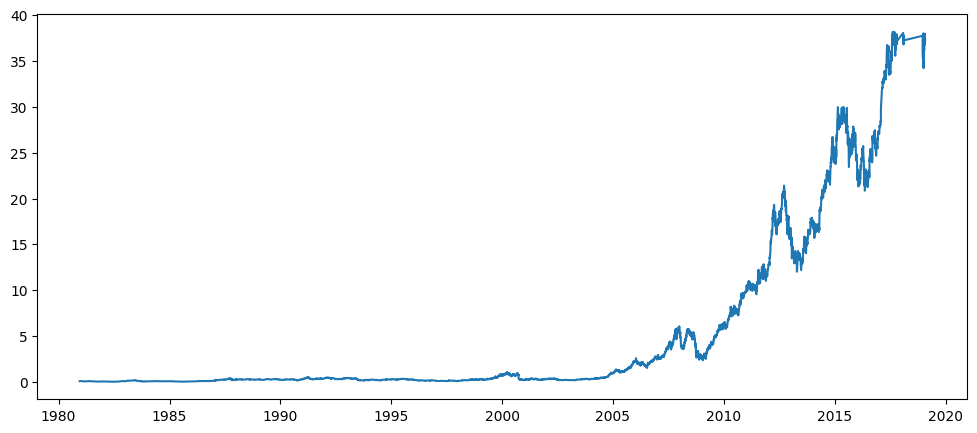

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 5]
plt.plot(dataset1)

In [13]:
#plt.rcParams["figure.figsize"] = (11,6)
from statsmodels.tsa.seasonal import seasonal_decompose, STL
Adj_close_decomposed1 = seasonal_decompose(dataset1,model='additive',period = 1)
Adj_close_decomposed2 = seasonal_decompose(dataset1,model='multiplicative' ,period =1)

<Figure size 1200x500 with 0 Axes>

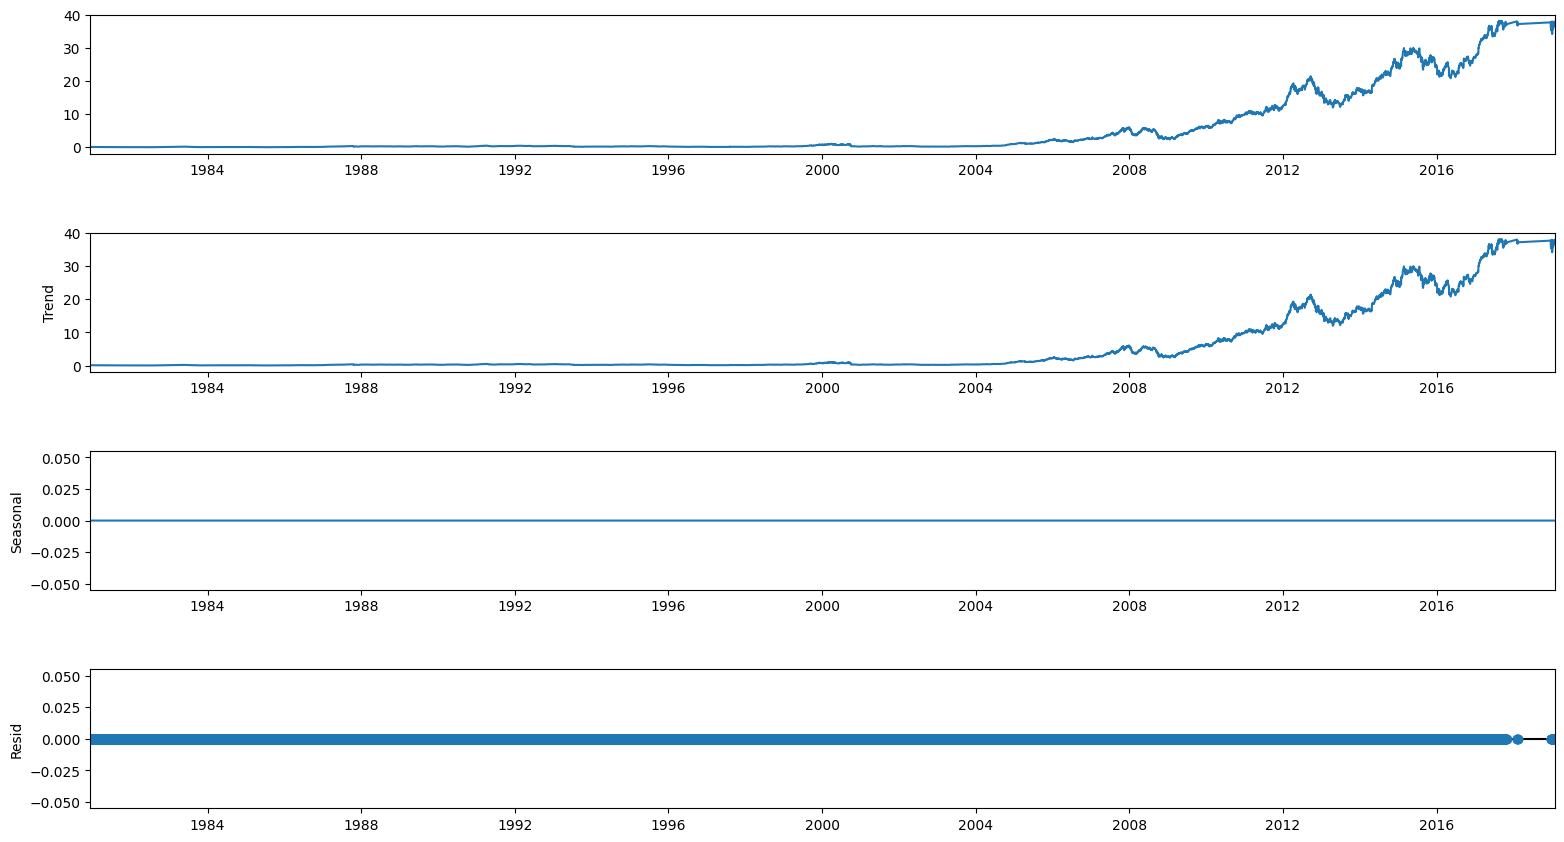

In [14]:
fig = plt.figure()
fig = Adj_close_decomposed1.plot()
fig.set_size_inches(16, 9)


<Figure size 1200x500 with 0 Axes>

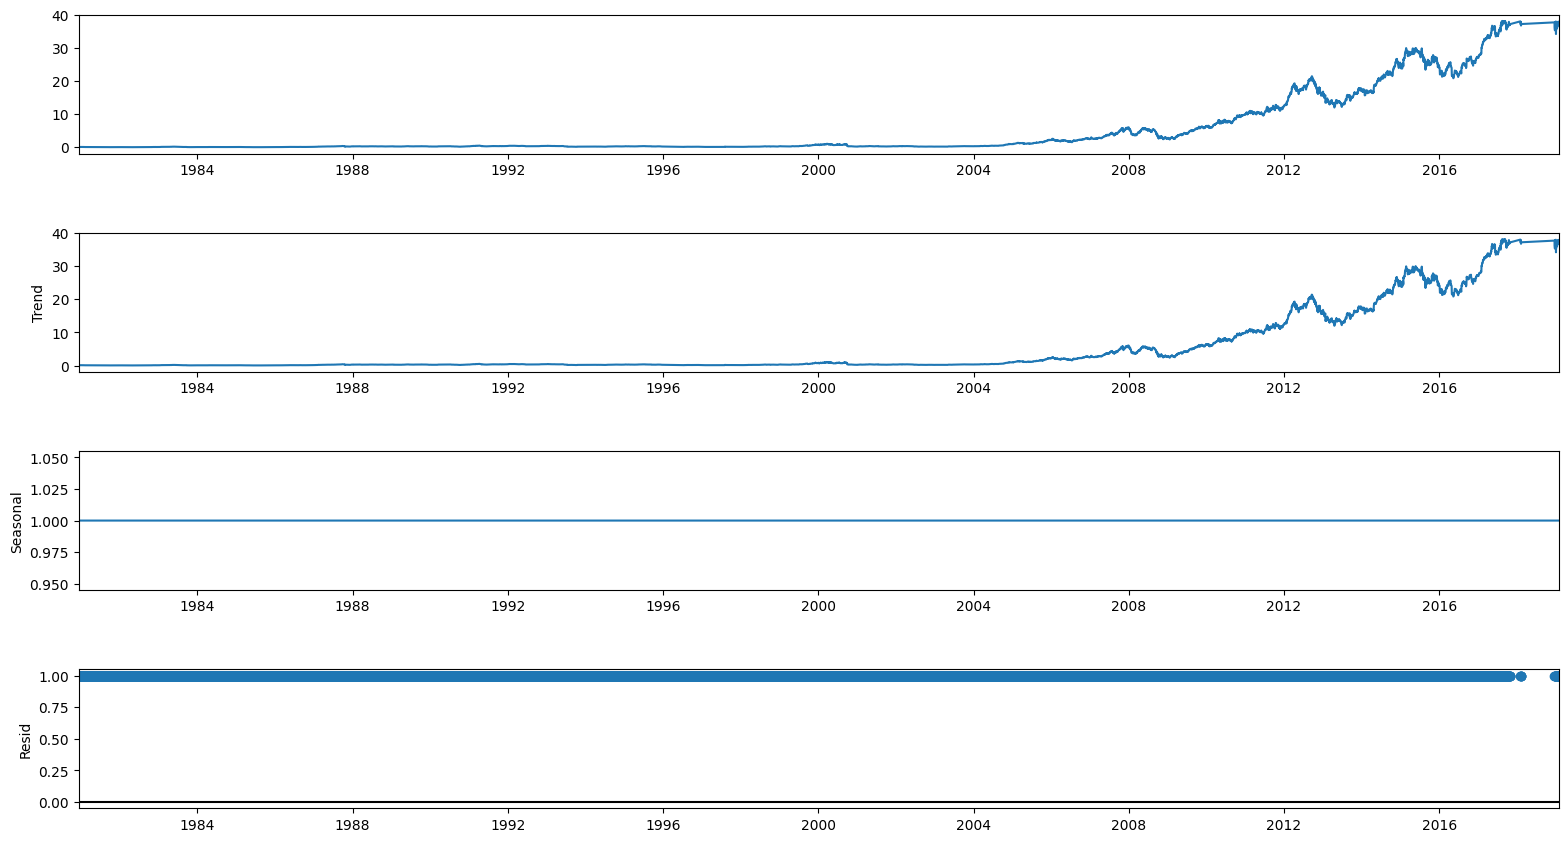

In [15]:
fig = plt.figure()
fig = Adj_close_decomposed2.plot()
fig.set_size_inches(16, 9)


In both model we can find that seasonal plot is straight line which implies absence of any seasonality

In [16]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [17]:
Adj_close_cyclic, Adj_close_trend = hpfilter(dataset1)

<Axes: title={'center': 'Adj close Trend Component'}, xlabel='Date'>

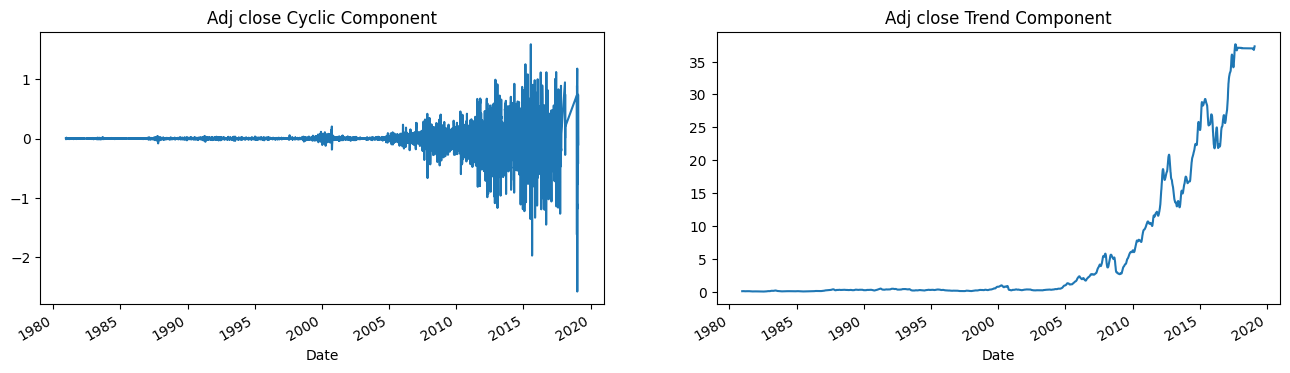

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
Adj_close_cyclic.plot(ax=ax[0], title='Adj close Cyclic Component')
Adj_close_trend.plot(ax=ax[1], title='Adj close Trend Component')

In [19]:
##checking stationarity
from statsmodels.tsa.stattools import adfuller, kpss
def print_results(output, test='adf'):

    pval = output[1]
    test_score = output[0]
    lags = output[2]

    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'

    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value

    return pd.Series(output_dict, name=test)

In [20]:
adf_output = adfuller(dataset1)
kpss_output = kpss(dataset1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [21]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,3.464988,9.318482
p-value,1.0,0.01
Numbers of lags,38,57
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.431054,0.739
Critical Value (5%),-2.861851,0.463
Critical Value (10%),-2.566936,0.347
Critical Value (2.5%),NaN,0.574


In [22]:
residual_additive_adf = adfuller(Adj_close_decomposed1.resid)
residual_multiplicative_adf = adfuller(Adj_close_decomposed2.resid)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [23]:
print_results(residual_additive_adf)

Test Statistic                     NaN
p-value                            NaN
Numbers of lags                      0
decision                Non-Stationary
Critical Value (1%)          -3.431052
Critical Value (5%)           -2.86185
Critical Value (10%)         -2.566935
Name: adf, dtype: object

In [24]:
print_results(residual_multiplicative_adf)

Test Statistic                     NaN
p-value                            NaN
Numbers of lags                      0
decision                Non-Stationary
Critical Value (1%)          -3.431052
Critical Value (5%)           -2.86185
Critical Value (10%)         -2.566935
Name: adf, dtype: object

In [25]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)

    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'

    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

In [26]:
def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type,
                    ax=ax[v,r],
                    legend=False,
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(52).mean().plot(ax=ax[v,r], legend=False)


In [27]:
# using first order differencing (detrending)
first_ord_diff = dataset1.diff().dropna()

In [28]:
# differencing to remove seasonality
diseasonalize = dataset1.diff(365).dropna()

In [29]:
# log transform
log_transform = np.log(dataset1)

In [30]:
# Square root transform
square_root = np.sqrt(dataset1)

In [31]:
# using hp_filter
cyclic_extract, trend = hpfilter(dataset1)

In [32]:
# using rolling mean
rolling_mean = dataset1.rolling(window=365).mean()
subt_roll_mean = dataset1 - rolling_mean

In [33]:
# combine the methods into a list
methods = [first_ord_diff,diseasonalize,
           log_transform, square_root,
           cyclic_extract,subt_roll_mean]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the 

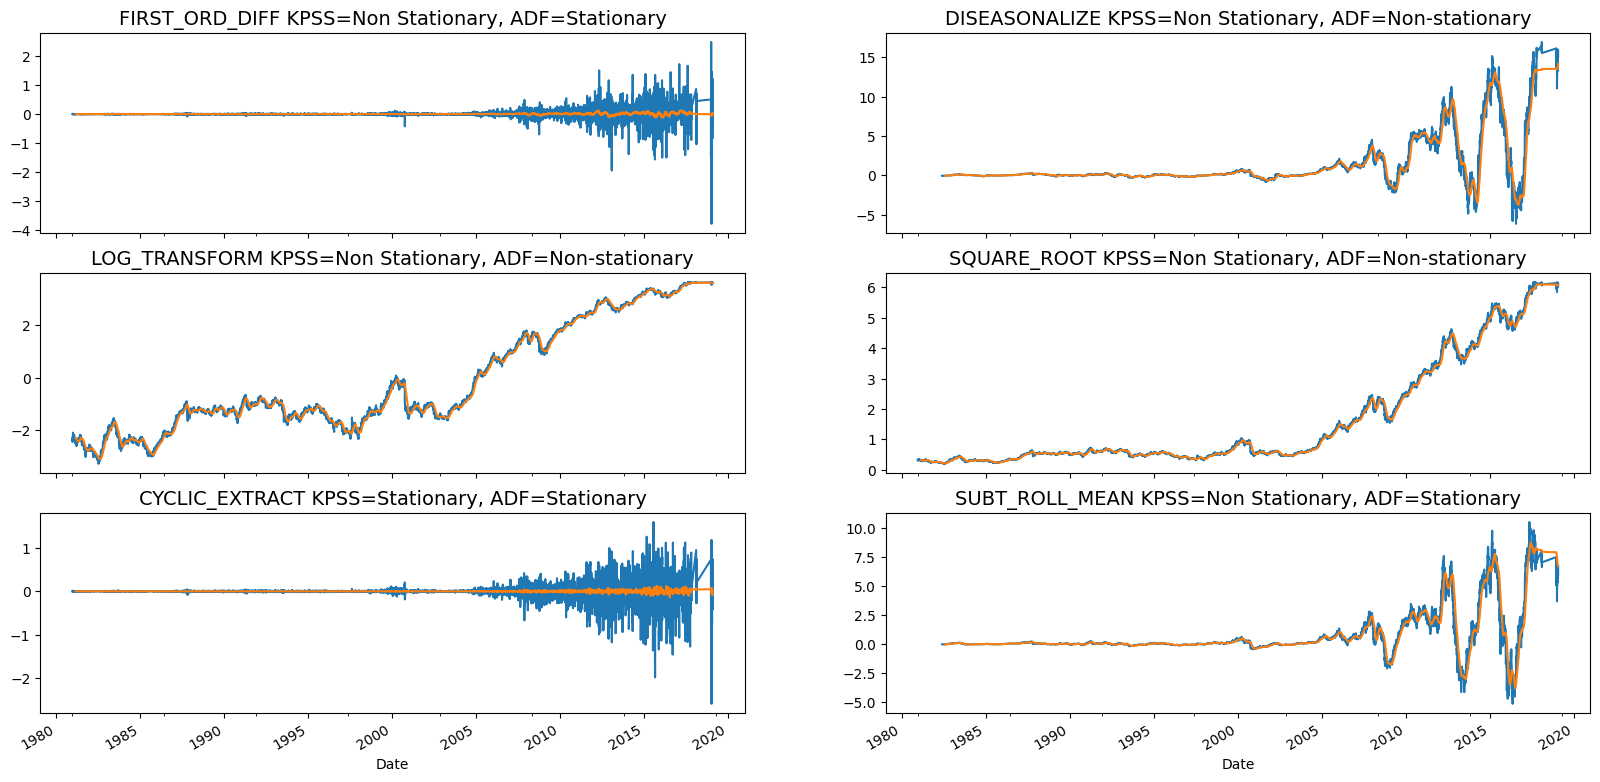

In [34]:
plot = plot_comparison(methods)

If we carefully observe then first order difference results in more stationarity than other method

In [35]:
#test for normality
from scipy.stats import shapiro
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [36]:
print(is_normal(shapiro(dataset1)))

Not Normal


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [37]:
print(is_normal(shapiro(first_ord_diff)))

Not Normal


Clearly none of the orginal and transformed series is normal

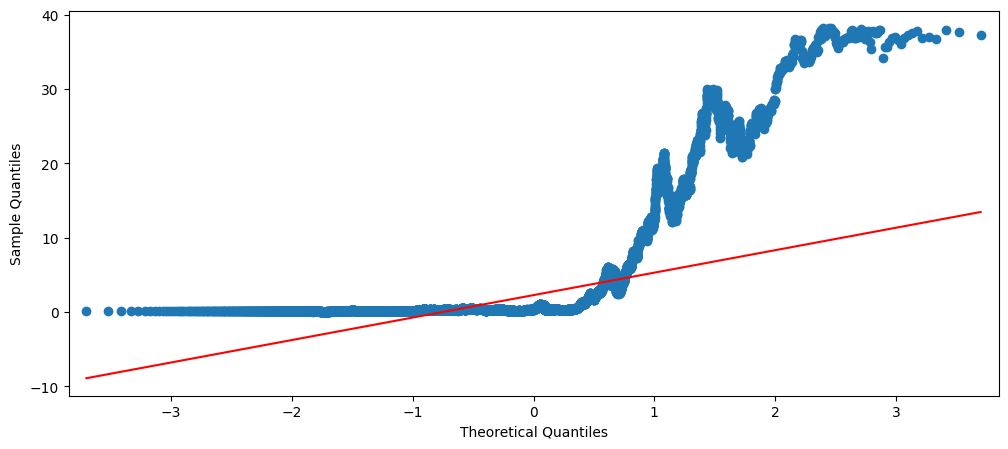

In [38]:
from statsmodels.graphics.gofplots import qqplot
qqplot(dataset1, line='q');

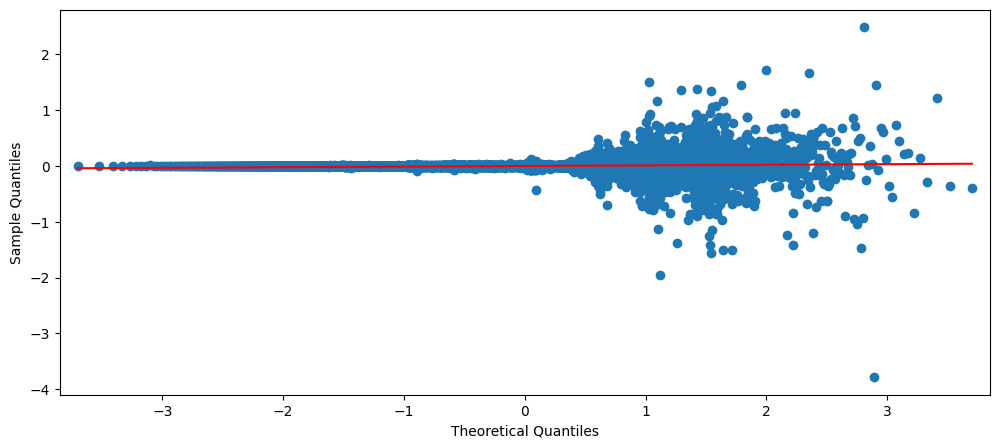

In [39]:
qqplot(first_ord_diff, line='q');

Since most of the points doesn't lie on a line so it is not normal

In [41]:
first_ord_diff.head()

,Adj Close
Date,
1980-12-15,-0.005195
1980-12-16,-0.006928
1980-12-17,0.002165
1980-12-18,0.002598
1980-12-19,0.005628


In [44]:
first_ord_diff.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
first_ord_diff.head()

,Adj_Close
Date,
1980-12-15,-0.005195
1980-12-16,-0.006928
1980-12-17,0.002165
1980-12-18,0.002598
1980-12-19,0.005628


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


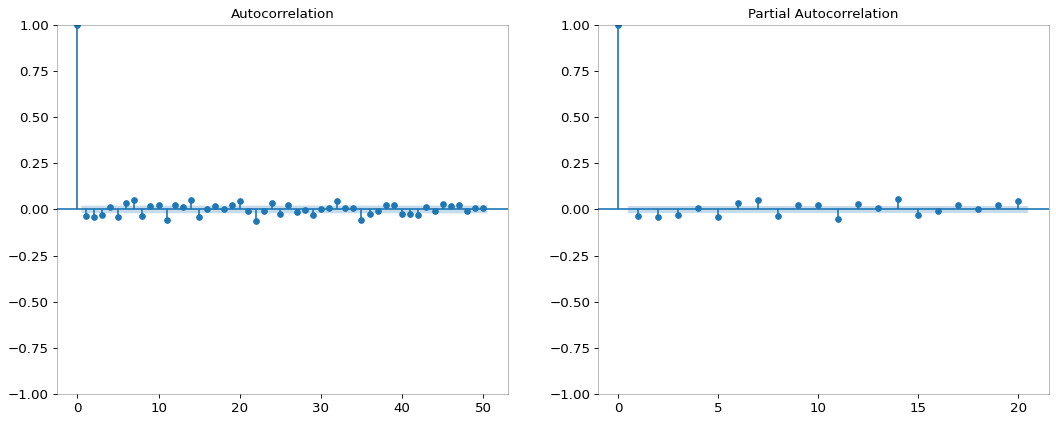

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi=80)
plot_acf(first_ord_diff.Adj_Close.tolist(), ax = ax1, lags=50)
plot_pacf(first_ord_diff.Adj_Close.tolist(), ax=ax2, lags=20)

#Decorate
#Lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

#font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [47]:
dataset1.head()

,Adj Close
Date,
1980-12-12,0.099584
1980-12-15,0.094388
1980-12-16,0.087461
1980-12-17,0.089625
1980-12-18,0.092224


In [48]:
dataset1.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
dataset1.head()

,Adj_Close
Date,
1980-12-12,0.099584
1980-12-15,0.094388
1980-12-16,0.087461
1980-12-17,0.089625
1980-12-18,0.092224


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


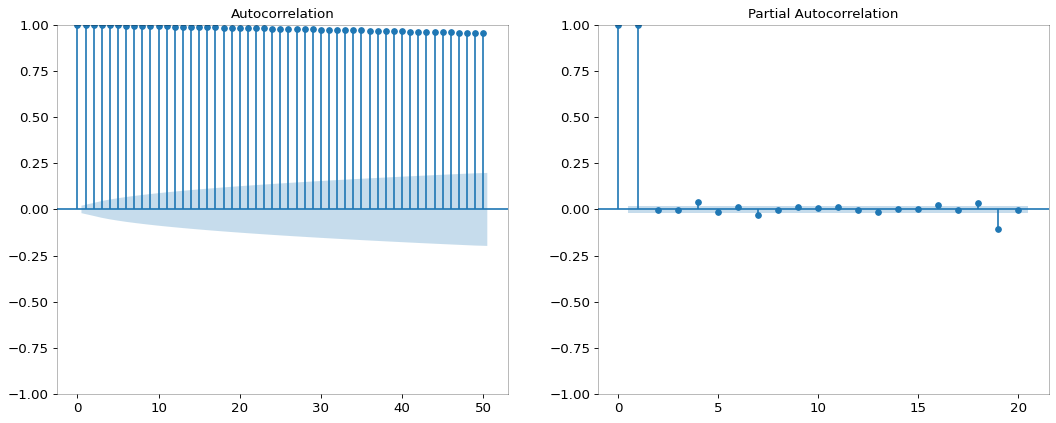

In [49]:
# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi=80)
plot_acf(dataset1.Adj_Close.tolist(), ax = ax1, lags=50)
plot_pacf(dataset1.Adj_Close.tolist(), ax=ax2, lags=20)

#Decorate
#Lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

#font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()